In [1]:
import jax.numpy as jnp
import jax
import numpy as np
from fbpinns.problems import Problem

class KovasznayFlow(Problem):
    """
    Solves the steady 2D incompressible Navier–Stokes equations (momentum + continuity)
    via the Kovasznay flow, defined on the domain [0,1] x [0,1].

    The equations are:
        u u_x + v u_y + p_x - ν (u_{xx}+u_{yy}) = 0,
        u v_x + v v_y + p_y - ν (v_{xx}+v_{yy}) = 0,
        u_x + v_y = 0,
    where ν is the kinematic viscosity.

    The exact solution is given by:
        u(x,y) = 1 - e^(λ x) cos(2π y),
        v(x,y) = (λ/(2π)) e^(λ x) sin(2π y),
        p(x,y) = ½ (1 - e^(2λ x)),
    with
        λ = Re/2 - sqrt((Re/2)^2+4π²),
        Re = 1/ν.
        
    For example, for Re=40 (ν=0.025) we have λ ≈ -0.952.
    
    We enforce the boundary conditions by reparameterizing the solution:
      u(x,y) = M(x,y)*N_u(x,y) + u_exact(x,y),
      v(x,y) = M(x,y)*N_v(x,y) + v_exact(x,y),
      p(x,y) = N_p(x,y) + p_exact(x,y),
    where M(x,y)=x(1-x)y(1-y) vanishes on ∂([0,1]×[0,1]).
    """

    @staticmethod
    def init_params(nu=0.025, sd=0.1):
        # Compute Reynolds number and λ
        Re = 1.0 / nu
        lam = Re / 2.0 - jnp.sqrt((Re/2.0)**2 + 4 * (jnp.pi**2))
        static_params = {
            "dims": (3, 2),  # 3 outputs: u, v, p; 2 inputs: x, y.
            "nu": nu,
            "lam": lam,
            "sd": sd,
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # Sample interior points from the domain [0,1] x [0,1]
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        # Request second derivatives for u and v, and first derivatives for p,
        # as well as first derivatives for the divergence condition.
        # Here we request:
        #   (0, (0,)) for u_x and (0, (1,)) for u_y,
        #   (0, (0,0)) for u_xx and (0, (1,1)) for u_yy,
        #   similarly for v,
        #   (2, (0,)) for p_x and (2, (1,)) for p_y.
        # To also enforce continuity u_x+v_y=0, we use the already requested u_x and v_y.
        required_diffs = (
            (0, ()),       # u
            (0, (0,)),     # u_x
            (0, (1,)),     # u_y
            (0, (0,0)),    # u_xx
            (0, (1,1)),    # u_yy
            (1, ()),       # v
            (1, (0,)),     # v_x
            (1, (1,)),     # v_y
            (1, (0,0)),    # v_xx
            (1, (1,1)), 
               # v_yy
            (2, ()),       # p
            (2, (0,)),     # p_x
            (2, (1,)),     # p_y
        )
        return [[x_batch_phys, required_diffs]]

    @staticmethod
    def constraining_fn(all_params, x_batch, net_out):
        """
        Reparameterizes the network output to enforce the boundary conditions.
        
        Let the raw network output be:
            N(x,y) = [N_u(x,y), N_v(x,y), N_p(x,y)].
        Then define the full solution as:
            u(x,y) = M(x,y)*N_u(x,y) + u_exact(x,y),
            v(x,y) = M(x,y)*N_v(x,y) + v_exact(x,y),
            p(x,y) = N_p(x,y) + p_exact(x,y),
        with the multiplier M(x,y)=x(1-x)y(1-y) which vanishes on the boundary.
        """
        x = x_batch[:, 0:1]
        y = x_batch[:, 1:2]
        sd, tanh = all_params["static"]["problem"]["sd"], jax.nn.tanh
        # M = x * (1 - x) * y * (1 - y)
        c = tanh((x)/sd) * tanh((1-x)/sd) * tanh((y)/sd) * tanh((1-y)/sd)
        
        # Extract exact solution (using lam and nu from static_params)
        lam = all_params["static"]["problem"]["lam"]
        pi = jnp.pi
        u_exact = 1 - jnp.exp(lam * x) * jnp.cos(2 * pi * y)
        v_exact = (lam / (2 * pi)) * jnp.exp(lam * x) * jnp.sin(2 * pi * y)
        p_exact = 0.5 * (1 - jnp.exp(2 * lam * x))
        
        # Split network outputs
        N_u = net_out[:, 0:1]
        N_v = net_out[:, 1:2]
        N_p = net_out[:, 2:3]
        
        u = c * N_u + u_exact
        v = c * N_v + v_exact
        p = N_p + p_exact
        return jnp.concatenate([u, v, p], axis=1)

    @staticmethod
    def loss_fn(all_params, constraints):
        # Retrieve the kinematic viscosity from the parameters.
        nu = all_params["static"]["problem"]["nu"]
        
        # Unpack the constraints array.
        # We assume constraints[0] contains:
        # [x_batch, u, u_x, u_y, u_xx, u_yy, v, v_x, v_y, v_xx, v_yy, p, p_x, p_y]
        (x_batch, u, u_x, u_y, u_xx, u_yy,
        v, v_x, v_y, v_xx, v_yy,
        p, p_x, p_y) = constraints[0]
        
        # Compute the momentum residuals.
        # Residual for the u-momentum equation:
        # R_u = u * u_x + v * u_y + p_x - nu*(u_xx + u_yy)
        residual_u = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        
        # Residual for the v-momentum equation:
        # R_v = u * v_x + v * v_y + p_y - nu*(v_xx + v_yy)
        residual_v = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
        
        # Compute the continuity residual:
        # R_c = u_x + v_y
        residual_c = u_x + v_y
        
        # Define the total loss as the sum of mean squared errors.
        loss_u = jnp.mean(residual_u ** 2)
        loss_v = jnp.mean(residual_v ** 2)
        loss_c = jnp.mean(residual_c ** 2)
        
        return loss_u + loss_v + loss_c, residual_u + residual_u + residual_c


    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        Returns the exact Kovasznay flow solution:
            u(x,y) = 1 - e^(λ x) cos(2π y),
            v(x,y) = (λ/(2π)) e^(λ x) sin(2π y),
            p(x,y) = ½ (1 - e^(2λ x)).
        """
        lam = all_params["static"]["problem"]["lam"]
        pi = jnp.pi
        x = x_batch[:, 0:1]
        y = x_batch[:, 1:2]
        u = 1 - jnp.exp(lam * x) * jnp.cos(2 * pi * y)
        v = (lam / (2 * pi)) * jnp.exp(lam * x) * jnp.sin(2 * pi * y)
        p = 0.5 * (1 - jnp.exp(2 * lam * x))
        return jnp.concatenate([u, v, p], axis=1)


[INFO] 2025-05-20 16:34:45 - <fbpinns.constants.Constants object at 0x7d305bb3a540>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.KovasznayFlow'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.  , 0.25, 0.5 , 0.75, 1.  ])], 'subdomain_ws': [array([0.725, 0.725, 0.725, 0.725, 0.725]), array([0.725, 0.725, 0.725, 0.725, 0.725])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.OptimizedStackedChebyshevKAN'>
network_init_kwargs: {'dims': [2, 4, 3], 'degrees': [8, 8]}
n_steps: 10000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((100, 100),)
n_test: (100, 100)
sampler: grid
optimiser: <function adam at 0x7d311a5e34c0>
optimiser_kwargs: {'learning_rate': 0.0001}
seed: 0
summary_freq: 1000

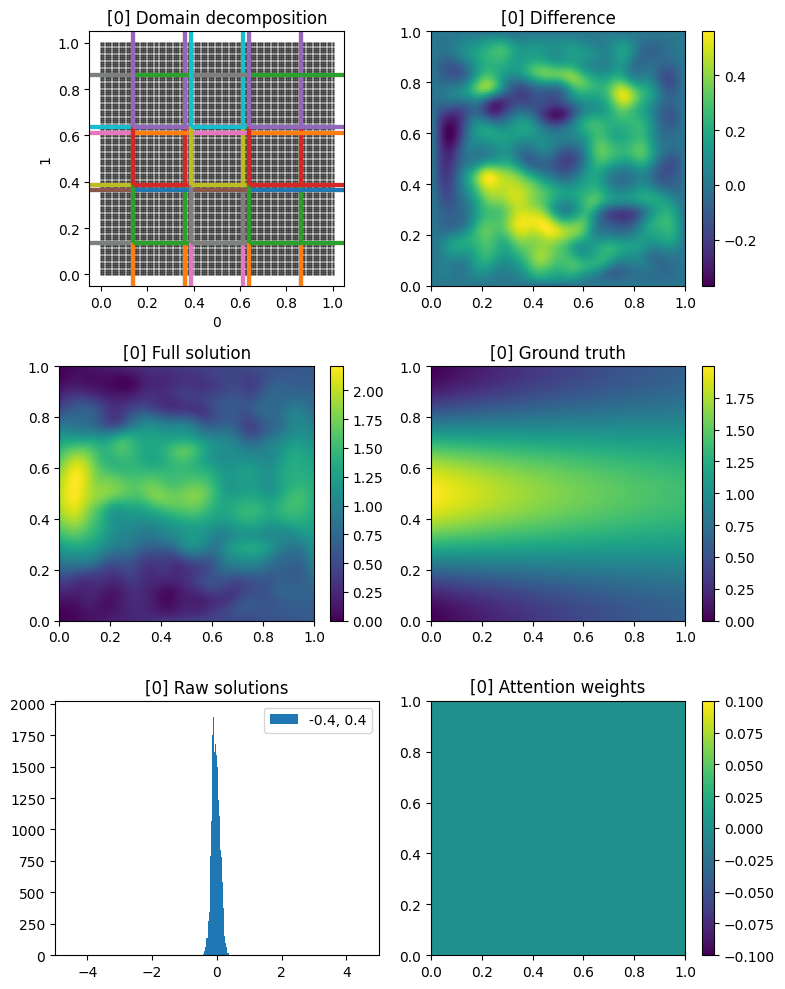

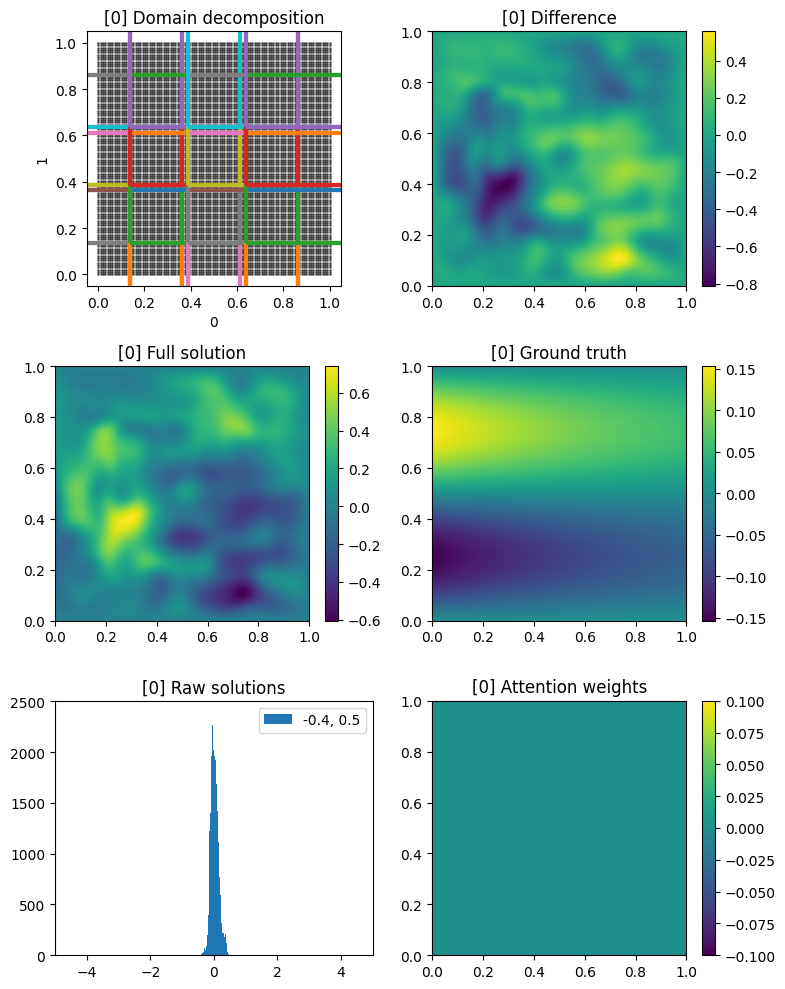

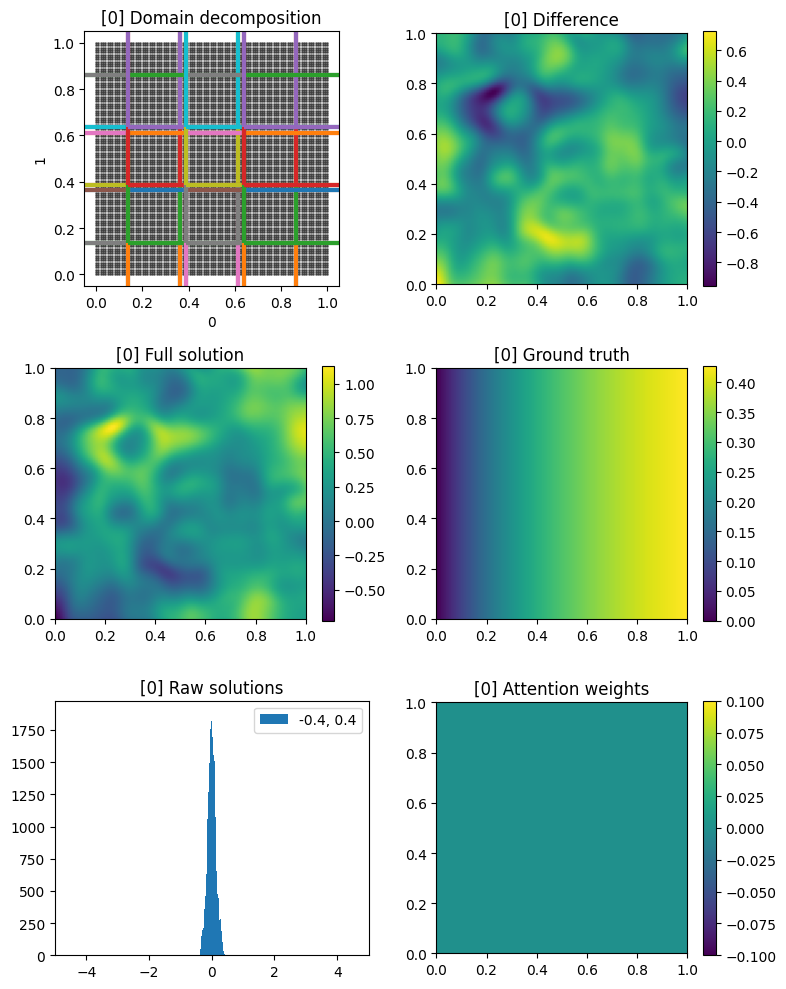

[INFO] 2025-05-20 16:35:21 - [i: 1000/10000] loss: 0.1137 rate: 43.8 elapsed: 0.01 hr test
[INFO] 2025-05-20 16:35:35 - [i: 2000/10000] loss: 0.0292 rate: 74.0 elapsed: 0.01 hr test
[INFO] 2025-05-20 16:35:49 - [i: 3000/10000] loss: 0.0118 rate: 71.9 elapsed: 0.02 hr test
[INFO] 2025-05-20 16:36:03 - [i: 4000/10000] loss: 0.0056 rate: 71.4 elapsed: 0.02 hr test
[INFO] 2025-05-20 16:36:17 - [i: 5000/10000] loss: 0.0029 rate: 72.1 elapsed: 0.02 hr test
[INFO] 2025-05-20 16:36:17 - saved arrays
[INFO] 2025-05-20 16:36:18 - saved arrays
[INFO] 2025-05-20 16:36:18 - saved arrays


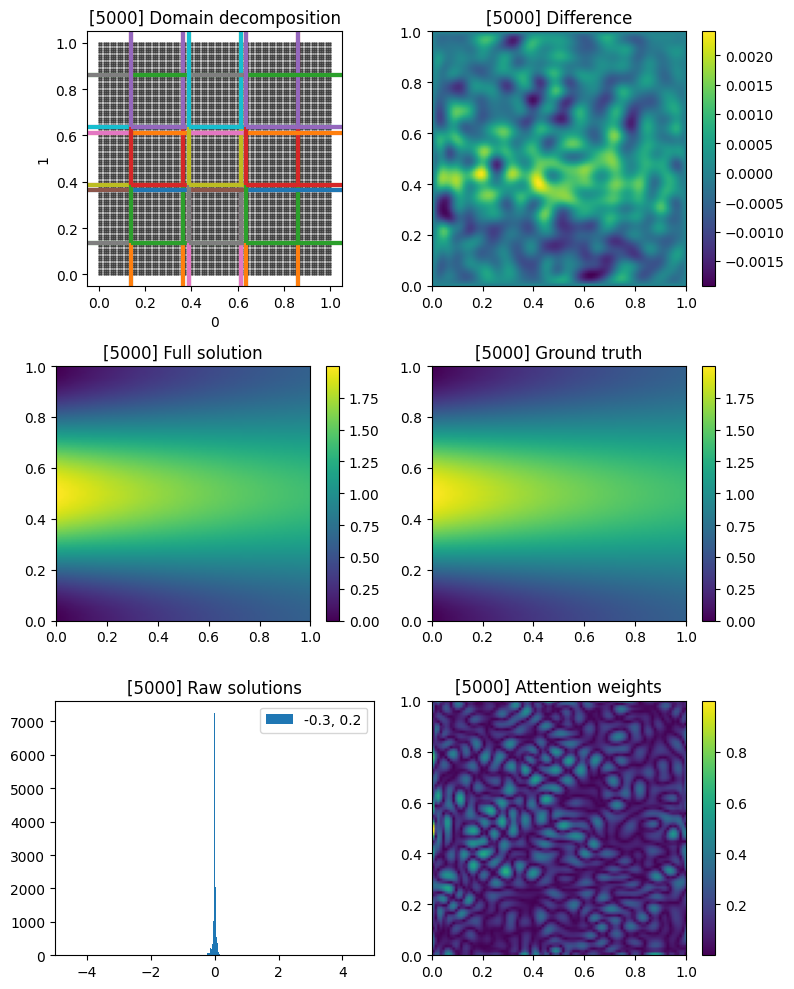

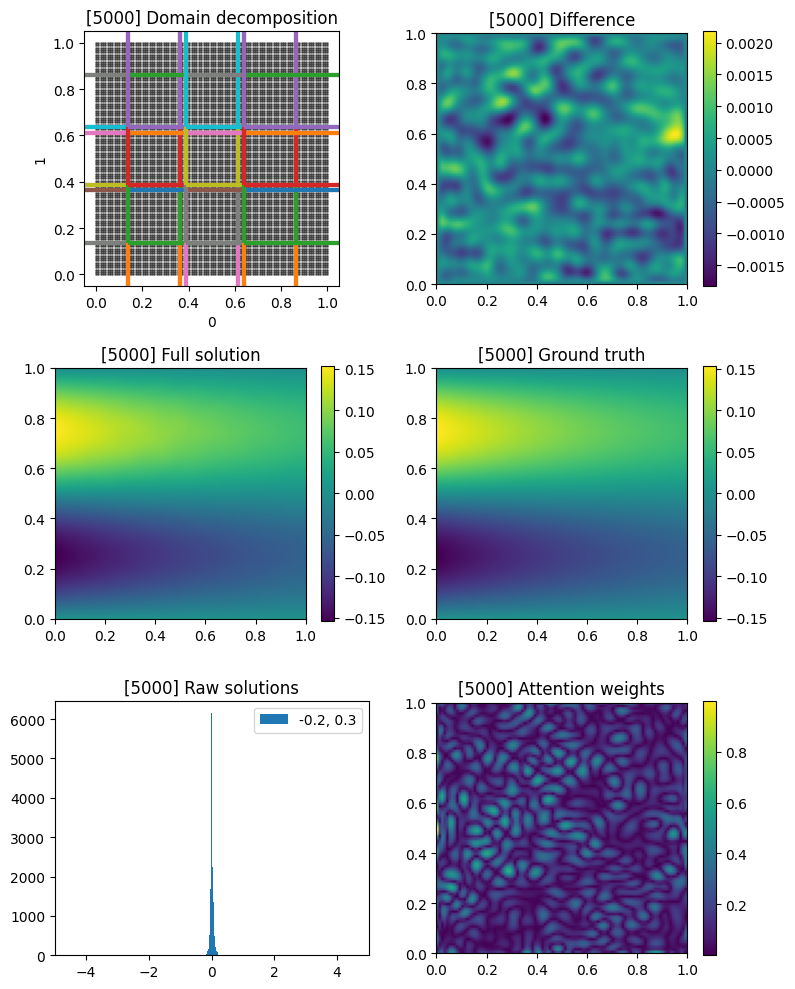

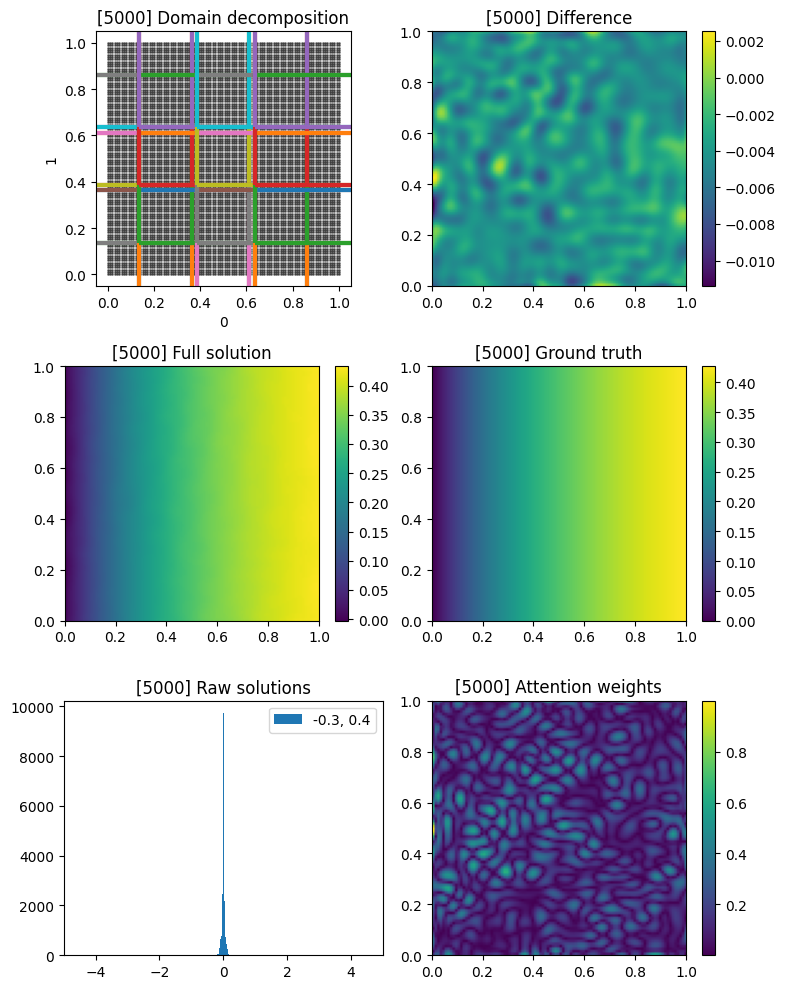

[INFO] 2025-05-20 16:36:34 - [i: 6000/10000] loss: 0.0017 rate: 72.6 elapsed: 0.03 hr test
[INFO] 2025-05-20 16:36:48 - [i: 7000/10000] loss: 0.0010 rate: 71.5 elapsed: 0.03 hr test
[INFO] 2025-05-20 16:37:02 - [i: 8000/10000] loss: 0.0006 rate: 71.1 elapsed: 0.04 hr test
[INFO] 2025-05-20 16:37:16 - [i: 9000/10000] loss: 0.0004 rate: 72.1 elapsed: 0.04 hr test
[INFO] 2025-05-20 16:37:30 - [i: 10000/10000] loss: 0.0002 rate: 71.9 elapsed: 0.04 hr test
[INFO] 2025-05-20 16:37:31 - saved arrays
[INFO] 2025-05-20 16:37:31 - saved arrays
[INFO] 2025-05-20 16:37:32 - saved arrays


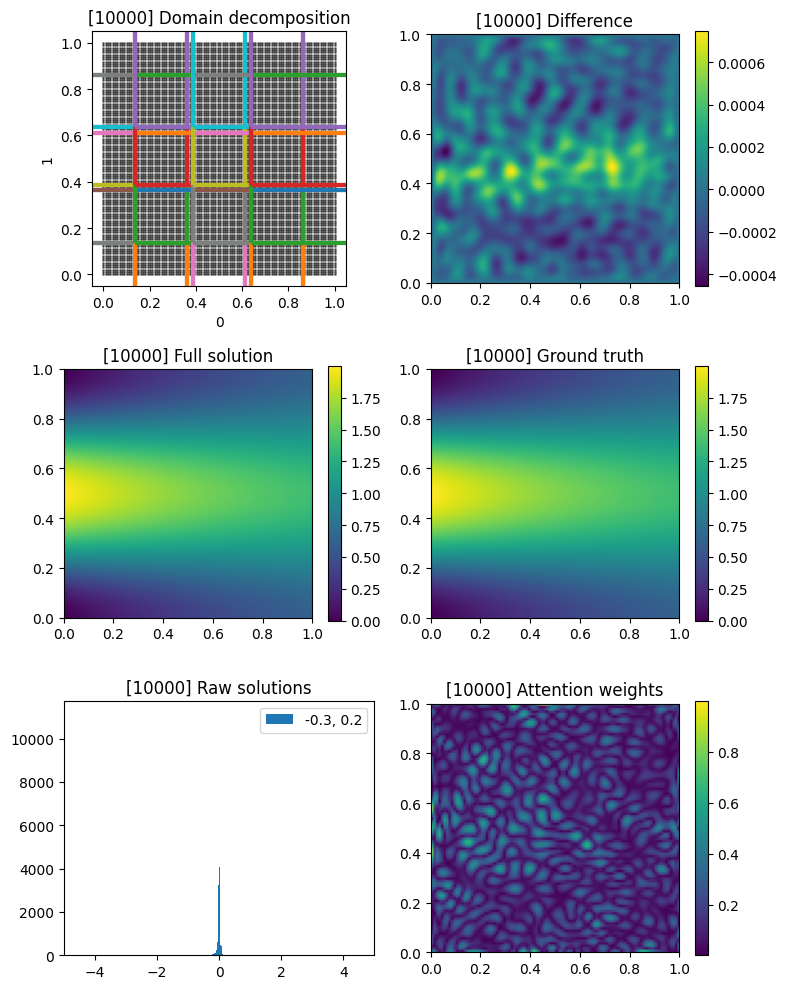

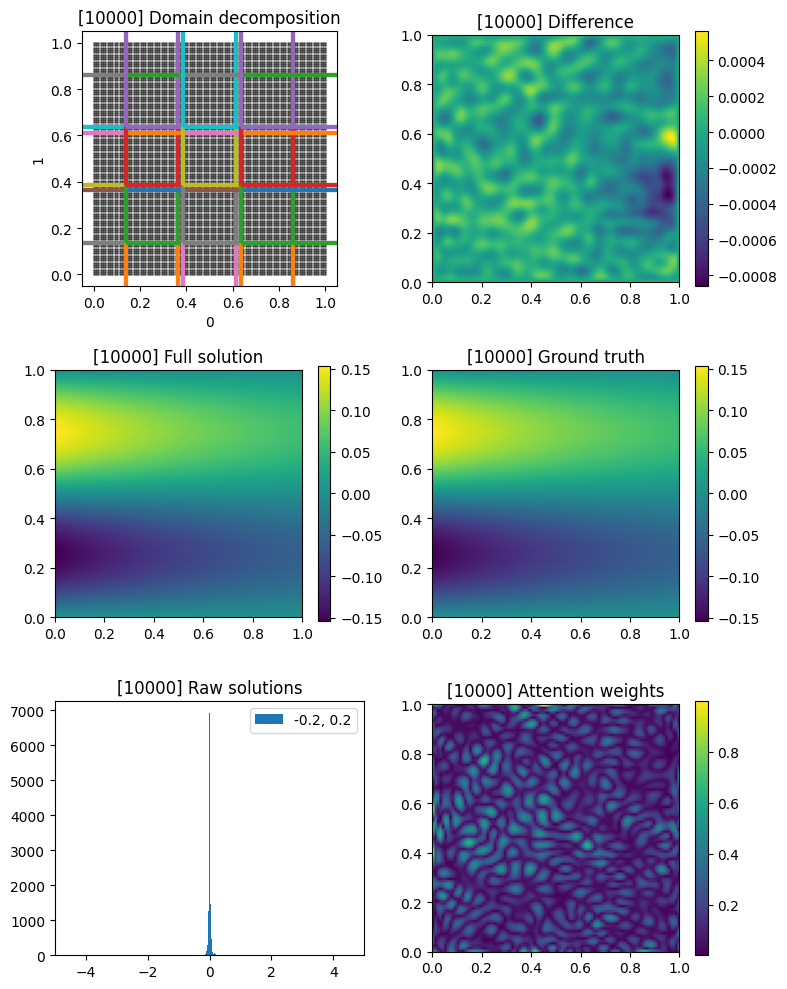

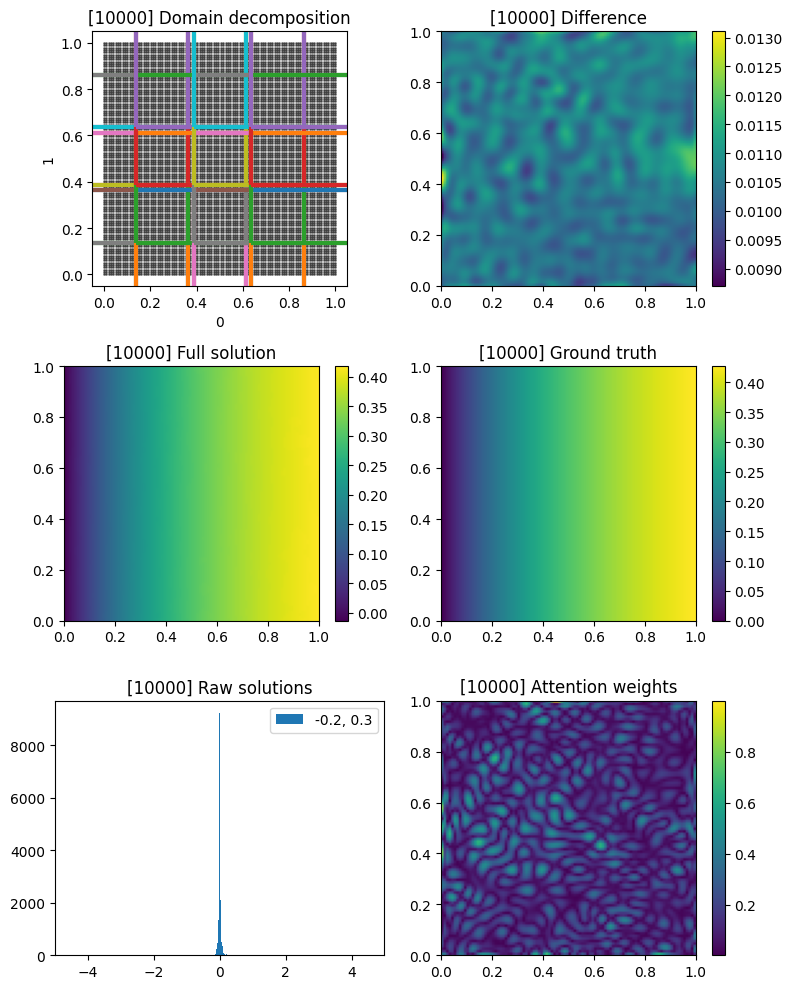

[INFO] 2025-05-20 16:37:34 - [i: 10000/10000] Training complete
[INFO] 2025-05-20 16:37:34 - [i: 10000/10000] Total training time: 160.13 s


In [2]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, StackedChebyshevKAN, StackedLegendreKAN, OptimizedChebyshevKAN, OptimizedStackedChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

x_min, x_max = 0., 1.
y_min, y_max = 0., 1.
subdomain_xs=[np.linspace(x_min, x_max, 5), np.linspace(y_min, y_max, 5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([x_min,y_min]),
        xmax=np.array([x_max,y_max])
        ),
    problem=KovasznayFlow,
    problem_init_kwargs = dict(
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 32, 3),
    # ),
    network=OptimizedStackedChebyshevKAN,# place a fully-connected network in each subdomain
    # network_init_kwargs=dict(
    #     input_dim=2,
    #     output_dim=3,
    #     degree=8,
    # ),
    network_init_kwargs=dict(
        dims=[2, 4, 3],
        degrees=[8, 8]
    ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=1,
    # ),
    optimiser_kwargs = dict(
        learning_rate=0.0001
        ),
    ns=((100,100),),
    n_test=(100,100),
    n_steps=10000,
    clear_output=False,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=10000
        ),
)

run = FBPINNTrainer(c)
all_params = run.train()